In [1]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data/'
filename = 'OK_county.json'

G = read_graph_from_json( filepath + filename )

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
k = 5          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 783952 and U = 799789 and k = 5


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03


In [6]:
# objective is to minimize weighted cut edges (district perimeter lengths)
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim'] * y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# To solve the MIP faster, fix some district roots:

r[6,0].LB = 1  # fix Oklahoma county as root of district 0
r[34,1].LB = 1 # fix Tulsa county as root of district 1
r[8,2].LB = 1  # fix Comanche county as root of district 2

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen Threadripper 3990X 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 1724 rows, 1355 columns and 6985 nonzeros
Model fingerprint: 0x8522f0f1
Variable types: 390 continuous, 965 integer (965 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [9e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 521 rows and 353 columns
Presolve time: 0.04s
Presolved: 1203 rows, 1002 columns, 4943 nonzeros
Variable types: 380 continuous, 622 integer (622 binary)

Root relaxation: objective 5.492575e+00, 991 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.49258    0  326          -  

In [11]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 12.457959326456109
District 0 has population 796292 and contains counties ['Oklahoma']

District 1 has population 785274 and contains counties ['Osage', 'Pawnee', 'Tulsa', 'Kay', 'Noble']

District 2 has population 795964 and contains counties ['Washita', 'Jackson', 'Major', 'Custer', 'Ellis', 'Comanche', 'Beckham', 'Garvin', 'Tillman', 'Jefferson', 'Beaver', 'Dewey', 'Roger Mills', 'Texas', 'Woodward', 'Stephens', 'Kingfisher', 'Grant', 'Murray', 'Grady', 'Cimarron', 'Garfield', 'Canadian', 'Harper', 'Alfalfa', 'Caddo', 'Carter', 'Greer', 'Cotton', 'Woods', 'Harmon', 'Blaine', 'Kiowa', 'Love']

District 3 has population 797224 and contains counties ['Delaware', 'Pushmataha', 'Wagoner', 'Craig', 'Cherokee', 'Pittsburg', 'Le Flore', 'Choctaw', 'Bryan', 'Latimer', 'McIntosh', 'Nowata', 'Haskell', 'Adair', 'Sequoyah', 'Marshall', 'Muskogee', 'Ottawa', 'Rogers', 'Mayes', 'McCurtain', 'Atoka', 'Washington']

District 4 has population 784599 and contains counties [

In [12]:
# Let's draw it on a map
import geopandas as gpd

In [13]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data/'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

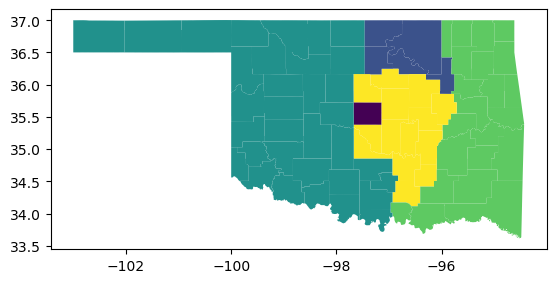

In [14]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()